*UID*:


# **CMSC426 Project 1: Color Segmentation using GMM**

# Introduction

Have you ever played with these adorable Nao robots? Click [here](http://www.youtube.com/watch?feature=player_embedded&v=Gy_wbhQxd_0) to watch a cool demo.

Nao robots are star players in RoboCup, an annual autonomous robot soccer competitions. Would you like to help us in Nao’s soccer training? We need to train Nao to detect a soccer ball and estimate the depth of the ball to know how far to kick.

Nao’s training has two phases:

- Color Segmentation using Gaussian Mixture Model (GMM)
- Ball Distance Estimation


<a name='problem'></a>
# What you need to do

To make logistics easier, we have collected camera data from Nao robot on behalf of you and saved the data in the form of color images. Click [here](https://drive.google.com/file/d/1k1dydl1Yho08isNg-_542fajXujybujH/view?usp=sharing) to download, or **run the following code block to download the training image folder to the file directory of the notebook**. The image names represent the depth of the ball from Nao robot in centimeters. -We will release the test dataset 48 hours before the deadline. **Test images are available [here](https://drive.google.com/file/d/1_qC1OnK58kYfBKZ9FUYnSmBLdfTpRmSr/view?usp=sharing) to download.**

In [2]:
# Download training images from Google Drive
import gdown
# gdown.download_folder(id="18Mx2Xc9UNFZYajYu9vfmRFlFCcna5I0J", quiet=True, use_cookies=False)

In [3]:
# Download testing images from Google Drive
# gdown.download_folder(id="1Yl4_5O_ZEkz_KJVs0_vS5TrZUqMYkwr4", quiet=True, use_cookies=False)

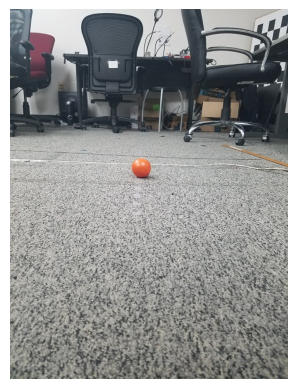

In [4]:
# Check whether the training images were successfully imported
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

train_image = mpimg.imread('./content/train_images/106.jpg')
plt.imshow(train_image)
plt.axis("off")
plt.show()

## Problem Statement

1. Write Python code to cluster the orange ball using [Single Gaussian](https://cmsc426.github.io/colorseg/#gaussian) [30 points]

In [ ]:
import os
import numpy as np 
import matplotlib.image as mpimg

def single_gaussian(test_image):

  # TODO: Read in training images
  training_images = []
  for image in os.listdir("./content/train_images"):
    training_images.append(mpimg.imread( "./content/train_images/"+str(image)))

  # TODO: Iterate over training images to extract orange pixels using masks
  extracted_orange_pixels = []
  total_pixels = 0
  total_orange_pixels = 0

  for image in training_images:
    # isolate each channel
    r = image[:, :, 0]
    g = image[:, :, 1]
    b = image[:, :, 2]

    # determine acceptable range of values per channel for orange (may need to be finetuned)
    mask = (r > 200) & (g > 70) & (g < 150) & (b < 60) 

    # store the pixels that fit this mask for a given image
    # image[mask] extracts the elements in image that are True for mask
    extracted_orange_pixels.append(image[mask])

    # store the total number of orange pixels found across images (for prior estimation)
    total_orange_pixels += np.sum(mask)
    
    # store the total number of pixels visited across images (for prior estimation)
    total_pixels += image.shape[0] * image.shape[1]


  # TODO: Compute mean and covariance using MLE(Maximum Likelihood Estimation)
  # combine all extracted orange pixels into one array  
  orange_pixels = np.concatenate(extracted_orange_pixels, axis=0)

  # calculate mean and covariance matrix for the idenfied orange pixels
  mean = np.mean(orange_pixels, axis=0)
  covariance_matrix = np.cov(orange_pixels, rowvar=False)

  # TODO: Compute PDF(Probability Density Function) of single gaussian model
  # will store the final PDF values per test pixel based on training data's mean and covariance, initialize with 0's as placeholders 
  pdf_matrix = np.zeros((test_image.shape[0], test_image.shape[1]))

  # compute the pdf per pixel in the testing image to compute the P(x|Orange), x being one pixel
  # use the mean and covariance matrix computed by the training data for this calculation to determine probability
  for outer_idx in range(0, test_image.shape[0]):
    for inner_idx in range(0, test_image.shape[1]):
      constant = 1 / (np.sqrt((2 * np.pi)**3 * np.linalg.det(covariance_matrix)))
      exponent = np.exp(-0.5 * ((test_image[outer_idx, inner_idx] - mean).T @ np.linalg.inv(covariance_matrix) @ (test_image[outer_idx, inner_idx] - mean)))
      pdf_matrix[outer_idx, inner_idx] = constant * exponent

  # TODO: Set parameters (threshold, prior)
  # estimate prior value as the ratio of orange pixels identified over total pixels process while training
  prior = total_orange_pixels/total_pixels

  # posterior = P(Orange | x) = pdf * prior value, 
  posterior = pdf_matrix * prior

  # determine a starting threshold to determine when to classify a test pixel as orange
  # may need to be adjusted, the best results were found with the 10th percentile of the posterior
  threshold = np.percentile(posterior, 5)

  orange_pixels_indexes = []
  orange_pixels_values = []

  # loop through each pixel in the test image to see if it's posterior value is greater than the threshold parameter
  for outer_idx in range(0, test_image.shape[0]):
    for inner_idx in range(0, test_image.shape[1]):
      # if the P(Orange) > threshold, then the pixel is classified as orange 
      # its position in the image and its rgb value is stored in result arrays
      if(posterior[outer_idx, inner_idx] > threshold):
        orange_pixels_indexes.append((outer_idx, inner_idx))
        orange_pixels_values.append(test_image[outer_idx, inner_idx])

  # return information about all of the pixels classified as orange in the test image 
  # not fully sure what I was supposed to return, can be adjusted based on Step 2
  return orange_pixels_indexes, orange_pixels_values

# TODO: Send test images into algorithm to detect orange ball
all_results_pixels = []
all_results_rgbs = []

# loop through each test image and pass it into this algorithm to idenity the orange pixels using the single gaussian method
for image in os.listdir("./content/test_images"):
  test_image = mpimg.imread( "./content/test_images/"+str(image))

  # accessing the position and the rgb value of a pixel classified as orange in the test image
  res_idxs, res_rgb = single_gaussian(test_image)

  # storing these results in a master array across all test images 
  all_results_pixels.append([res_idxs])
  all_results_rgbs.append([res_rgb])


In [6]:
# Show you result here

# orange pixel positions per test image
for elem in all_results_pixels:
    print(elem)

print("_______________________________")

# pixel rgb values per test image
for elem in all_results_rgbs:
    print(elem)


[[(25, 42), (25, 43), (25, 44), (25, 45), (25, 46), (25, 47), (25, 48), (25, 49), (25, 50), (25, 51), (25, 52), (26, 42), (26, 43), (26, 44), (26, 45), (26, 46), (26, 47), (26, 48), (26, 49), (26, 50), (26, 51), (26, 52), (26, 53), (26, 54), (26, 55), (26, 56), (26, 57), (26, 58), (26, 59), (26, 60), (27, 42), (27, 43), (27, 44), (27, 45), (27, 46), (27, 47), (27, 48), (27, 49), (27, 50), (27, 51), (27, 52), (27, 53), (27, 54), (27, 55), (27, 56), (27, 57), (27, 58), (27, 59), (27, 60), (27, 61), (27, 62), (27, 63), (27, 64), (27, 65), (28, 42), (28, 43), (28, 44), (28, 45), (28, 46), (28, 47), (28, 48), (28, 49), (28, 50), (28, 51), (28, 52), (28, 53), (28, 54), (28, 55), (28, 56), (28, 57), (28, 58), (28, 59), (28, 60), (28, 61), (28, 62), (28, 63), (28, 64), (28, 65), (28, 66), (28, 67), (28, 68), (28, 69), (28, 70), (29, 41), (29, 42), (29, 43), (29, 44), (29, 45), (29, 46), (29, 47), (29, 48), (29, 49), (29, 50), (29, 51), (29, 52), (29, 53), (29, 54), (29, 55), (29, 56), (29, 57)

2. Write Python code to cluster the orange ball using [Gaussian Mixture Model](https://cmsc426.github.io/colorseg/#gmm) [40 points] and estimate the [distance](https://cmsc426.github.io/colorseg/#distest) to the ball [20 points]. Also, plot all the GMM ellipsoids [10 points].


You are NOT allowed to use any built-in Python package(s) like *sklearn.mixture.GaussianMixture* for GMM. To help you with code implementation, we have given the pseudocode :-)

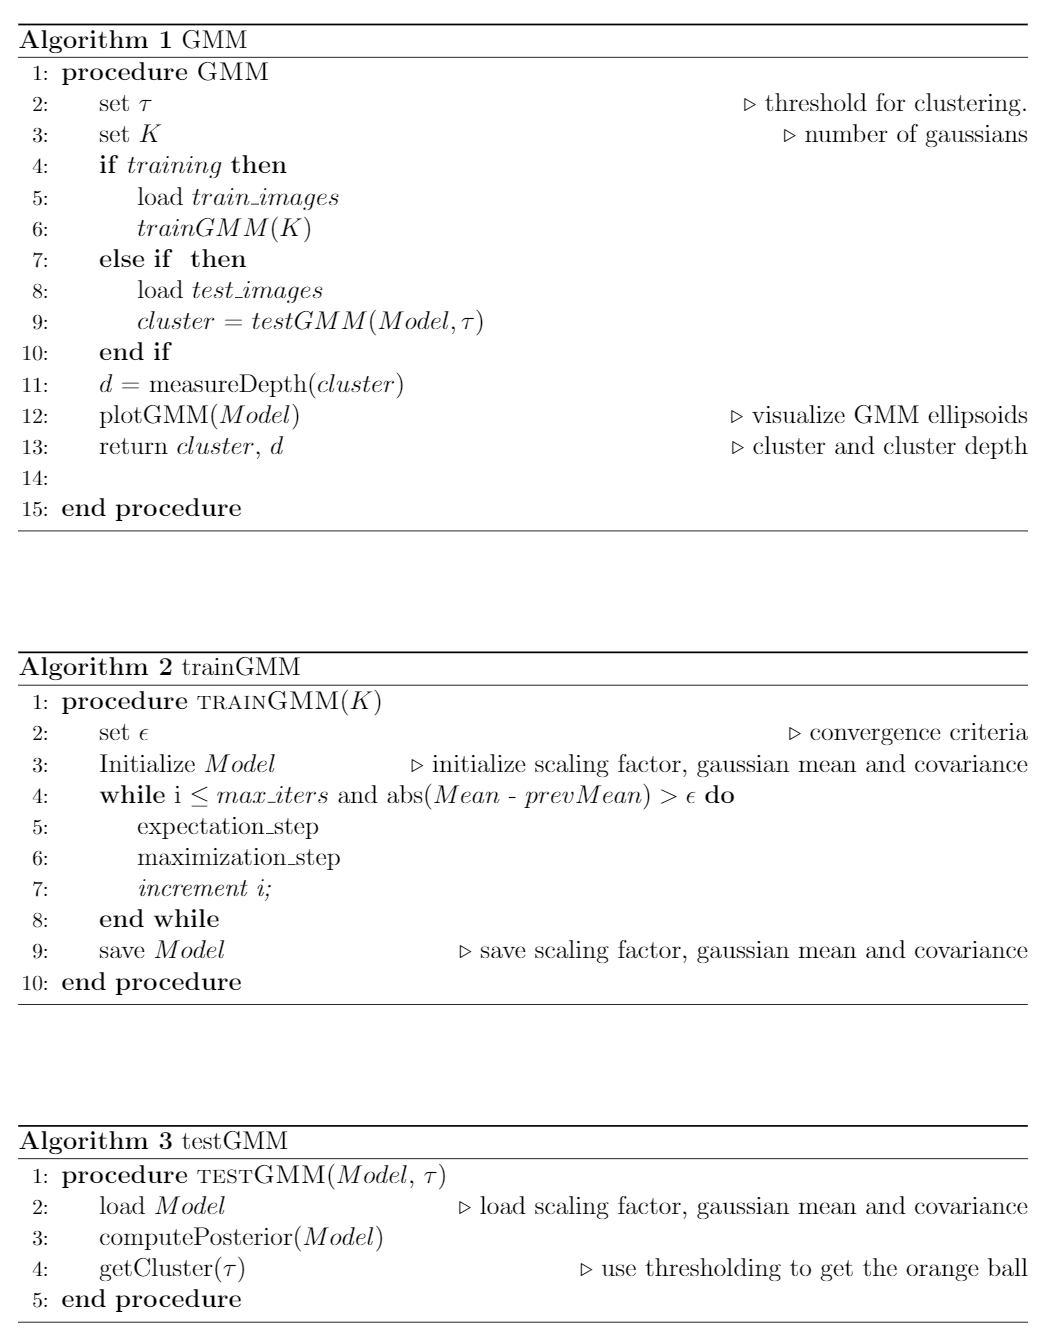

In [7]:
import os

In [ ]:

def trainGMM(K):
  training_images, pixel_num = [], 307200*23

  # Get training images
  for image in os.listdir("./content/train_images"):
    training_images.append(mpimg.imread( "./content/train_images/"+str(image)))

  # Extract pixels and flatten in 1d array
  r, g, b = np.zeros(pixel_num), np.zeros(pixel_num), np.zeros(pixel_num)
  img_num = 0
  for image in training_images:
    r[img_num*307200:(img_num+1)*307200] = image[:, :, 0].flatten()
    g[img_num*307200:(img_num+1)*307200] = image[:, :, 1].flatten()
    b[img_num*307200:(img_num+1)*307200] = image[:, :, 2].flatten()

  # Randomly initiate per cluster
  rng = np.random.default_rng()
  pi = rng.integers(low=0, high=255, size=K)
  mu = rng.integers(low=0, high=255, size=(K,3))
  cov = rng.integers(low=0, high=255, size=(K, 3))
  
  # TODO figure out threshold
  threshold = 0.1

  curr_iter, max_iter = 0, 1000
  alpha = np.zeros((K, pixel_num))

  while curr_iter <= max_iter:
    # Expectation Step
    denom = 0
    for k in range(K):
      for j in range(pixel_num):
        # calculating numerator: pi_subscript_i * posterior probability
        base = 1 / np.sqrt((2 * np.pi)**3 * np.linalg.det(cov[K]))
        exp = (-1/2) * (np.array([r, g, b]) - mu[k]).T * np.linalg.inv(cov[k]) * (np.array([r, g, b] - mu[k]))
        num = pi[k] * base ** exp
        alpha[k][j] = num
        denom += num
    
    # Divide everything by denominator
    for i in np.nditer(alpha):
      i = i / denom
    
    # Maximization Step

    # Calculating mu
    num = 0
    denom = 0

    # TODO check this
    for k in range(K):
      for j in range(pixel_num):
        num += alpha[k][j] * np.array([r, g, b])
        denom += alpha[k][j]

      current_mu = num / denom
      mu[k] = current_mu
    
    # Calculating sigma
    num = 0
    denom = 0
    for k in range(K):
      for j in range(pixel_num):
        num += alpha[k][j] * (np.array([r, g, b]) - mu[k]) * (np.array([r, g, b]) - mu[k]).T
        denom += alpha[i][j]
    
      cov[k] = num / denom
    
    # Calculating pi (scaling factor)
    summation = 0

    for k in range(K):
      for j in range(pixel_num):
        summation += alpha[k][j]
      
      pi[k] = 1 / (pixel_num) * summation

    
    # TODO Keep track of vars, fix convergence
    former_mu = current_mu
    curr_iter += 1

    # is convergent?
    is_convergence = True
    for k in range(K):
      convergence = np.linalg.norm(mu - former_mu)
      if cov[k] * convergence > threshold:
        is_convergence = False
        continue
    return pi, mu, cov

In [9]:
def testGMM(Model_parameters,threshold,prior):
  pass
# TODO:  Read test images
  # '''Enter your code here'''

# TODO:  Main testing loop over all test images and use thresholding to get the orange ball
  # '''Enter your code here'''

# TODO: Saving predictions to the result folder
  # '''Enter your code here'''

  return cluster_parameters

In [10]:
def measureDepth(cluster_parameters):
  # hint: fit a simple parametric model (choose a model of your choice) to estimate distance from different parameters based on the image. For eg. area of the ball on the image decreases with distance (generally follows a inverse square curve).
  pass
# TODO: Identify the pixels which belong to the orange ball
  # '''Enter your code here'''

# TODO: Use the data provided and any feature you like to obtain a model to estimate distance. eg. area of the ball on the image decreases with distance (generally follows a inverse square curve)
  # '''Enter your code here'''

  return distance

In [11]:
def plotGMM(Model_parameters,distance):
  pass
# TODO: Visualize GMM ellipsoids
  # '''Enter your code here'''

In [12]:
# Main function (Algorithm 1 in the pseudocode above)

# -Write Python code to cluster the orange ball using Gaussian Mixture Model [40 points].

# -Estimate the distance to the ball [20 points].

# -Plot all the GMM ellipsoids [10 points].




# TODO: Import all python packages you need


threshold = 0.1 # Threshold for clustering (Set it to an appropriate value)
K = 2 # Number of gaussians (Set it to an appropriate value)

mode_flag = 0 # (Set it to 0 for training, 1 for testing)

if mode_flag == 0:

# TODO: Read in training images
  # '''Enter your code here'''

# TODO: Iterate over training images to extract orange pixels using masks
  # '''Enter your code here'''

  trainGMM(K)
else:

  # TODO: Load Model
  # '''Enter your code here'''

  cluster_parameters = testGMM(K, scalars, means, covariances, threshold, prior)
  distance = measureDepth(cluster_parameters)
  plotGMM(means, covariances, scalars, distance)


[[[118 134 149]
  [123 139 154]
  [119 135 150]
  ...
  [205 209 210]
  [205 209 212]
  [206 210 213]]

 [[111 127 142]
  [118 134 149]
  [116 132 147]
  ...
  [206 210 211]
  [207 211 214]
  [207 211 214]]

 [[117 133 148]
  [110 126 141]
  [114 130 143]
  ...
  [208 212 213]
  [206 211 214]
  [206 211 214]]

 ...

 [[148 153 147]
  [154 159 153]
  [149 154 148]
  ...
  [133 133 133]
  [108 108 110]
  [ 90  89  94]]

 [[154 159 155]
  [160 165 161]
  [152 157 153]
  ...
  [161 161 159]
  [132 131 136]
  [ 75  74  80]]

 [[163 168 164]
  [155 160 156]
  [148 153 149]
  ...
  [141 141 139]
  [114 113 118]
  [ 95  94 100]]]


NameError: name 'scalars' is not defined

# Video Lecture
Click [here](https://www.youtube.com/watch?v=D5AcaFMY_BI) for a video lecture to help you better understand the project.

## Report
For each section of the project, explain briefly what you did, and describe any interesting problems you encountered and/or solutions you implemented. You must include the following details in your writeup:

- Your choice of color space, initialization method and number of gaussians in the GMM
- Explain why GMM is better than single gaussian
- Present your distance estimate and cluster segmentation results for each test image
- Explain strengths and limitations of your algorithm. Also, explain why the algorithm failed on some test images

As usual, your report must be full English sentences, not commented code. There is a word limit of 1500 words and no minimum length requirement.

## ***add your report here***


# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj1.pdf**. For example, xyz123_proj1.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to Gradescope
.**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2025
 website.